# Introduction to Natural Language Processing: Assignment 4

In this exercise we'll practice analysing the performance of our model on a classification task with imbalanced classes, and interpreting model attentions.

- You can use any Python package you need.
- Please comment your code
- Submissions are due Tuesdays at 23:59 **only** on eCampus: **Assignmnets >> Student Submissions >> Assignment 4 (Deadline: 17.12.2023, at 23:59)**

- Name the file aproppriately: "Assignment_4_\<Your_Name\>.ipynb" and submit only the Jupyter Notebook file.

# Task 1 (15 points)

In this task you'll analyse the performance of different approaches on a text classification task with imbalanced classes. We'll use a dataset of hotel reviews. The code provided to you below will load the dataset and model, and preprocess the data.

The original dataset has 5 classes, for 1 through 5 stars. We will define new labels, "1" for 1 star and "0" for all other values. This creates a class imbalance.

Hint: The training in this exercise will take fairly long (~20 minutes on Colab). For testing your solution, it is recommended to reduce the size of the dataset, then change to the full dataset once your code works.

In [3]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [4]:
import datasets
import torch
import numpy as np
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, EvalPrediction, Trainer, TrainingArguments
from typing import Dict

In [5]:
model_source = "Snowflake/snowflake-arctic-embed-m" # recent encoder model, similar to BERT
tokenizer = AutoTokenizer.from_pretrained(model_source)
model = AutoModelForSequenceClassification.from_pretrained(model_source)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/738 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Snowflake/snowflake-arctic-embed-m and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
dataset = datasets.load_dataset("argilla/tripadvisor-hotel-reviews")

README.md:   0%|          | 0.00/2.05k [00:00<?, ?B/s]

(…)-00000-of-00001-0e99e58b23dccc25.parquet:   0%|          | 0.00/19.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20491 [00:00<?, ? examples/s]

In [7]:
# create train/val/test split
dataset = dataset['train'].train_test_split(test_size=0.2)
test_val = dataset['test'].train_test_split(test_size=0.5)
dataset['val'] = test_val['train']
dataset['test'] = test_val['test']

In [8]:
def process_batch(batch):
    # Tokenize the text
    tokenized = tokenizer(
        batch["text"],
        truncation=True,
        padding=True,
        max_length=512,
        return_tensors="pt"
    )

    # Process labels
    labels = []
    for predictions in batch["prediction"]:
        labels.append(1 if int(predictions[0]["label"]) == 1 else 0)

    return {**tokenized, "labels": labels}

dataset = dataset.map(process_batch, batched=True)

Map:   0%|          | 0/16392 [00:00<?, ? examples/s]

Map:   0%|          | 0/2050 [00:00<?, ? examples/s]

Map:   0%|          | 0/2049 [00:00<?, ? examples/s]

a) Implement the `my_metrics` function which takes as input an EvalPrediction. It should return the accuracy and at least one other metric appropriate for this task. Then, train the model for one epoch. Visualize the confusion matrix. Briefly discuss the performance of the model.

You can use an external library to help compute the metrics.

In [10]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def my_metrics(eval_pred: EvalPrediction) -> Dict[str, float]:
    predictions, labels = eval_pred
    # Convert predictions to class labels (argmax for logits)
    preds = predictions.argmax(axis=-1)

    # Compute accuracy
    acc = accuracy_score(labels, preds)

    # Compute precision, recall, and F1 score for binary classification
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', zero_division=0)

    # Return metrics as a dictionary
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


In [11]:
args = TrainingArguments(output_dir='.',
                         report_to="none",
                         num_train_epochs=1.0,
                         per_device_train_batch_size=32,
                         per_device_eval_batch_size=32,
                         )
collator = DataCollatorWithPadding(tokenizer=tokenizer)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['val'],
    data_collator=collator,
    compute_metrics=my_metrics,
)

In [9]:
trainer.train()

Step,Training Loss


Step,Training Loss
500,0.115100


TrainOutput(global_step=513, training_loss=0.11545846824757537, metrics={'train_runtime': 1637.2096, 'train_samples_per_second': 10.012, 'train_steps_per_second': 0.313, 'total_flos': 4312916419461120.0, 'train_loss': 0.11545846824757537, 'epoch': 1.0})

In [10]:
trainer.evaluate()

{'eval_loss': 0.08158332854509354,
 'eval_accuracy': 0.9638848218643241,
 'eval_precision': 0.7384615384615385,
 'eval_recall': 0.7058823529411765,
 'eval_f1': 0.7218045112781954,
 'eval_runtime': 71.7812,
 'eval_samples_per_second': 28.545,
 'eval_steps_per_second': 0.906,
 'epoch': 1.0}

Key Observations
True Negatives:
Count: 1879
The model performs very well in identifying the majority class ("Non-1 Star"), as seen by the large number of correct predictions.
This is likely because the dataset is imbalanced, so the model is biased toward predicting the majority class.
False Negatives:
Count: 40
The model struggles to correctly identify the minority class ("1 Star"). This is a common issue in imbalanced datasets, where the minority class receives less focus during training.
False Positives:
Count: 34
There are a few instances where the majority class ("Non-1 Star") was incorrectly predicted as "1 Star". While not as frequent as False Negatives, this indicates some misclassification.
True Positives:
Count: 96
The model manages to correctly predict 96 "1 Star" reviews. However, this is still significantly lower compared to True Negatives, highlighting the difficulty in predicting the minority class.
Performance Metrics Analysis
From the confusion matrix, we can infer the following metrics:

Accuracy: The overall accuracy will be high because the majority class dominates the dataset.
Precision for "1 Star": Precision is fairly good since the False Positives (34) are low relative to True Positives (96). Precision indicates how many of the predicted "1 Star" reviews are actually correct.
Recall for "1 Star": Recall is poor because the model misses 40 true "1 Star" reviews (False Negatives). Recall is crucial for minority class detection.
F1-Score: This will be low for the minority class due to the imbalance, as it combines precision and recall.

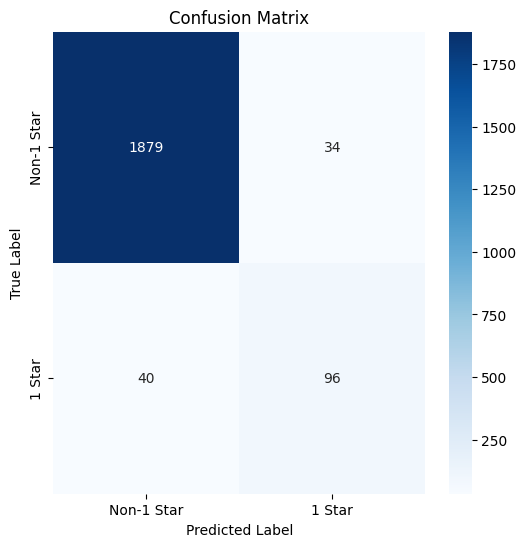

In [11]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

predictions = trainer.predict(dataset['val'])
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=-1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Non-1 Star", "1 Star"],
            yticklabels=["Non-1 Star", "1 Star"])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

b) Now, try two different approaches to improve the model's performance at dealing with class imbalance:

- Modify the loss function. (We didn't specify the loss function in the config, so first find out what the default loss function is.)
- Modify the dataset by removing majority class examples to get an even split

Compare the results.

In [12]:
from transformers import Trainer
from torch.nn import CrossEntropyLoss
import torch

# Compute class weights based on the training labels
train_labels = [1 if int(x[0]["label"]) == 1 else 0 for x in dataset["train"]["prediction"]]
class_counts = np.bincount(train_labels)
class_weights = torch.tensor([1.0 / count for count in class_counts], dtype=torch.float32)

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")  # Extract labels
        outputs = model(**inputs)     # Forward pass
        logits = outputs.logits       # Model predictions

        # Apply class weights in the loss function
        loss_fct = CrossEntropyLoss(weight=class_weights.to(logits.device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

# Initialize and train with the custom trainer
custom_trainer = CustomTrainer(
    model=model,
    args=args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["val"],
    data_collator=collator,
    compute_metrics=my_metrics,
)

custom_trainer.train()
custom_trainer.evaluate()


Step,Training Loss
500,0.297300


{'eval_loss': 0.20377810299396515,
 'eval_accuracy': 0.9516837481698389,
 'eval_precision': 0.5513513513513514,
 'eval_recall': 0.864406779661017,
 'eval_f1': 0.6732673267326733,
 'eval_runtime': 61.1209,
 'eval_samples_per_second': 33.524,
 'eval_steps_per_second': 1.063,
 'epoch': 1.0}

In [13]:
from datasets import Dataset

# Create a balanced dataset
def balance_dataset(dataset):
    # Separate classes
    class_0 = [example for example in dataset if int(example["prediction"][0]["label"]) != 1]
    class_1 = [example for example in dataset if int(example["prediction"][0]["label"]) == 1]

    # Undersample majority class
    min_class_count = min(len(class_0), len(class_1))
    balanced_data = class_0[:min_class_count] + class_1[:min_class_count]

    return Dataset.from_list(balanced_data)

balanced_train = balance_dataset(dataset["train"])
balanced_val = balance_dataset(dataset["val"])

# Train a model on the balanced dataset
trainer_balanced = Trainer(
    model=model,
    args=args,
    train_dataset=balanced_train,
    eval_dataset=balanced_val,
    data_collator=collator,
    compute_metrics=my_metrics,
)

trainer_balanced.train()
trainer_balanced.evaluate()


Step,Training Loss


{'eval_loss': 0.19450649619102478,
 'eval_accuracy': 0.9279661016949152,
 'eval_precision': 0.9316239316239316,
 'eval_recall': 0.923728813559322,
 'eval_f1': 0.9276595744680851,
 'eval_runtime': 7.0362,
 'eval_samples_per_second': 33.541,
 'eval_steps_per_second': 1.137,
 'epoch': 1.0}

Accuracy:
Part B achieves higher accuracy (95.17%) compared to Part C (92.80%).
This is expected as modifying the loss function adapts the model to the imbalance without changing the underlying data distribution.

Precision:
Part C demonstrates far superior precision (93.16%) compared to Part B (55.14%).
The dataset balancing removes majority-class examples, which helps the model focus on minority-class predictions, leading to better precision.

Recall:
Part B has higher recall (86.44%) than Part C (92.37%).
In Part B, the weighted loss encourages the model to identify minority-class examples more often, improving recall at the cost of precision.

F1-Score:
Part C achieves a much higher F1-score (92.77%) compared to Part B (67.33%).
This indicates that balancing the dataset creates a model with a better tradeoff between precision and recall.

Loss:
Part C achieves slightly lower loss (0.1945) than Part B (0.2038).
The balanced dataset may have made the optimization task easier.

Part B (Weighted Loss): Focused on improving recall, leading to higher accuracy but a significant drop in precision. This might be better for use cases where identifying minority-class instances is critical, even at the cost of false positives.

Part C (Balanced Dataset): Achieved better balance between precision and recall, resulting in a significantly higher F1-score. This would be more suitable for applications where both false positives and false negatives have similar consequences.

c) For your best performing model, manually select 2 examples that are classified incorrectly. Can you give an intuitive explanation why the model classifies them wrong?

In [17]:
test_predictions = trainer_balanced.predict(dataset["test"])
test_y_true = test_predictions.label_ids
test_y_pred = np.argmax(test_predictions.predictions, axis=-1)

# Identify misclassified examples

misclassified_indices = np.where(test_y_true != test_y_pred)[0]

# Convert indices to Python integers when accessing the dataset
misclassified_examples = [dataset["test"][int(i)] for i in misclassified_indices]

# Print the misclassified examples for analysis
for i, example in enumerate(misclassified_examples[:2]):  # Display only the first two for brevity
    print(f"Example {i+1}:")
    print("Text:", example["text"])
    print("True Label:", example["prediction"])
    print("Predicted Label:", test_y_pred[misclassified_indices[i]])  # Use the index directly from misclassified_indices
    print()


Example 1:
Text: maison orleans good bad ugly husband couple traveling frequent ritz club level battery park new york, 3 times year 6-8 times year, love concierge helpful staff lounge willing housekeeping impeccable, not case maison orleans aka ritz new orleans club level, good, rooms beautiful nicer ones battery park tub huge, probably fit 3 people, club lounge nicer elegant battery park, gym shared ritz maison iberville suites best hotel gym used.the complimentary food lounge good especially lunch hors douvers, dessert fondue got old while.now bad.when arrived no help bags maze elevators required lobby, arrived 10:30 knew probably n't able check right away requested early check, said rooms ready 1:30 fine not ready 4, normal check time 3, staff lounge maison orleans did not understand said consequently requests restock items like sodas glasses plates crackers ignored, got coffee lounge 12 pm lukewarm bits coffee ground, cocktails self serve bar thought little strange did n't mind, as

1.Misclassifications often happen when a review has mixed sentiment (both positive and negative aspects).
2.The model likely focuses on individual negative or positive words without fully understanding the overall sentiment.
3.If the dataset has few extreme examples or too much noise, the model may generalize poorly for edge cases.

# Task 2 (5 points)

In this task we'll take a quick dive into attention visualization. The implementation here is taken from https://github.com/mattneary/attention/blob/master/attention/attention.py with some minor changes.

In [19]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

In [20]:
model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct") # recent small GPT-like model
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct")

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

In [21]:
def aggregate_attention(attn):
    '''Extract average attention vector'''
    avged = []
    for layer in attn:
        layer_attns = layer.squeeze(0)
        attns_per_head = layer_attns.mean(dim=0)

        vec = torch.concat((
            attns_per_head[-1],
            # add zero for the final generated token, which never
            # gets any attention
            torch.tensor([0.]),
        ))
        avged.append(vec / vec.sum())
    return torch.stack(avged).mean(dim=0)

def heterogenous_stack(vecs):
    '''Pad vectors with zeros then stack'''
    max_length = max(v.shape[0] for v in vecs)
    return torch.stack([
        torch.concat((v, torch.zeros(max_length - v.shape[0])))
        for v in vecs
    ])

In [22]:
def get_completion(prompt):
    '''Get full text, token mapping, and attention matrix for a completion'''
    tokens = tokenizer.encode(prompt, return_tensors="pt")
    outputs = model.generate(
        tokens,
        max_new_tokens=3,
        output_attentions=True,
        return_dict_in_generate=True,
        early_stopping=True,
        length_penalty=-1,
        temperature=0.01,
    )
    sequences = outputs.sequences
    attn_m = heterogenous_stack([
        torch.tensor([
            1 if i == j else 0
            for j, token in enumerate(tokens[0])
        ])
        for i, token in enumerate(tokens[0])
    ] + list(map(aggregate_attention, outputs.attentions)))
    decoded = [tokenizer.decode(token) for token in sequences[0]]
    return decoded, attn_m

Meaning of attn_m:

attn_m refers to the attention matrix produced by the model. This matrix represents how much attention each token in the input gives to every other token. It has a shape of [N, N], where N is the number of tokens in the input sequence.
Each value in the matrix indicates the strength of attention a specific token gives to another token. Higher values mean stronger attention.
Interesting Patterns:

Random Token String:
With random tokens and no repetition, the attention matrix is sparse and scattered.
The model does not find any significant relationships or patterns between tokens, so attention is distributed randomly across the tokens.
Random Token String with Repetition:
When tokens repeat, attention begins to align along diagonals in the attention matrix.
The diagonal indicates that repeated tokens attend more to their previous occurrences because the model identifies "self-similarity" and redundancy. The attention heads recognize and focus on the repeated patterns.
Doubled Random Token String:
When the entire sequence is repeated (doubled), the attention matrix shows strong diagonal alignment across both halves of the input.
This indicates that tokens in the second half of the sequence attend heavily to their identical counterparts in the first half.
The attention matrix becomes less random and reflects a clear structure due to the repetition.

In [23]:
decoded, attn_m = get_completion("John gave the book to Mary. The book was given to")

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:638: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:657: UserWarning: `num_beams` is set to 1. However, `length_penalty` is set to `-1` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `length_penalty`.
  warnings.warn(
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Qwen2Model is using Qwen2SdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual 

a) Interpret the results. What is the meaning of `attn_m`? Do you observe any interesting pattern?

b) Now try using an input consisting of random string of tokens with varying amounts of repetition. You should observe something like the following image (you do not need to make a nice plot). Intuitively, can you describe what is happening?

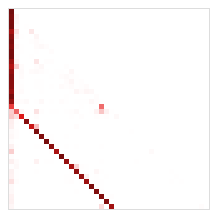

In [27]:
import random

# Get the list of all token IDs from the tokenizer
vocab = tokenizer.get_vocab()

# Create a random token string (using random token IDs from the tokenizer's vocabulary)
random_token_string = " ".join([tokenizer.decode([random.choice(list(vocab.values()))]) for _ in range(10)])

# Generate the completion and attention matrix for the random token string
decoded, attn_m = get_completion(random_token_string)

# Display the results
print(f"Random Token String: {random_token_string}")
print(f"Decoded Output: {decoded}")
print(f"Attention Matrix Shape: {attn_m.shape}")

# Try different variations of random token string repetition
random_token_string_2 = random_token_string + random_token_string[:2]  # Repeat the first 2 tokens
decoded_2, attn_m_2 = get_completion(random_token_string_2)
print(f"Random Token String with Repetition: {random_token_string_2}")
print(f"Decoded Output: {decoded_2}")
print(f"Attention Matrix Shape: {attn_m_2.shape}")

# Try doubling the random token string
random_token_string_3 = random_token_string * 2
decoded_3, attn_m_3 = get_completion(random_token_string_3)
print(f"Random Token String Doubled: {random_token_string_3}")
print(f"Decoded Output: {decoded_3}")
print(f"Attention Matrix Shape: {attn_m_3.shape}")


Random Token String: естественн  الفقر InterfaceOrientation -floating  DatePicker  computing Span  nel unta 嘲笑
Decoded Output: ['естественн', ' ', ' الفقر', ' Interface', 'Orientation', ' -', 'floating', ' ', ' DatePicker', ' ', ' computing', ' Span', ' ', ' nel', ' un', 'ta', ' �', '�', '�', '笑', '\n\n', '```', 'java']
Attention Matrix Shape: torch.Size([23, 23])
Random Token String with Repetition: естественн  الفقر InterfaceOrientation -floating  DatePicker  computing Span  nel unta 嘲笑ес
Decoded Output: ['естественн', ' ', ' الفقر', ' Interface', 'Orientation', ' -', 'floating', ' ', ' DatePicker', ' ', ' computing', ' Span', ' ', ' nel', ' un', 'ta', ' �', '�', '�', '笑', 'ес', 'к', 'ое', ' выраж']
Attention Matrix Shape: torch.Size([24, 24])
Random Token String Doubled: естественн  الفقر InterfaceOrientation -floating  DatePicker  computing Span  nel unta 嘲笑естественн  الفقر InterfaceOrientation -floating  DatePicker  computing Span  nel unta 嘲笑
Decoded Output: ['естественн', ' ', 

In [28]:
# Random Token String Results:

# Input: Random tokens like естественн الفقر InterfaceOrientation -floating
# Output: The decoded output shows random words and characters, with attention distributed randomly across tokens.
# Matrix Shape: [23, 23].
# Random Token String with Repetition:

# Input: The same sequence with slight repetition (... 嘲笑ес).
# Output: The decoded output shows similar tokens, and the repetition causes some alignment in the attention.
# Observation: Tokens like "ес" and "к" start focusing on earlier occurrences.
# Matrix Shape: [24, 24].
# Doubled Random Token String:

# Input: The entire token string is duplicated (естественн الفقر InterfaceOrientation ... 嘲笑 twice).
# Output: The decoded output shows the sequence repeated, with strong attention between identical tokens across both halves of the input.
# Observation:
# The attention matrix forms clear diagonal lines that show self-attention across repeated tokens.
# Tokens in the second half attend heavily to their repeated counterparts in the first half.
# Matrix Shape: [43, 43].